This code uses the saved precipitation thresholds saved for each day and uses NH threshold for nITCZ, SH threshold for sITCZ, and either the larger of the two thresholds (NH or SH threshold), the mean of the two thresholds (NH and SH), or the SH threshold, to compare the precipitation threshold distributions between single and double ITCZs in observations, reanalyses, and CMIP6 models. 

In [1]:
#Author: Alex Gonzalez
#Date: November 2025
#Paper: JGR-Atmospheres

Figure 12. 90th percentile precipitation threshold distribution (mm day−1) of nITCZ (blue
shading), sITCZ (gold shading), and dITCZ (red shading) during January through May in a)
IMERG combined microwave and IR (MW+IR), IMERG microwave only (MW+IR), and GPCP
observations against ERA5, MERRA-2, JRA-3Q, and CFSR reanalyses (1998–2024), b) IMERG
(MW+IR) observations (1998–2024) vs. CMIP6 models with significant nITCZs (1980–2014), and
c) IIMERG (MW+IR) observations (1998–2024) vs. CMIP6 models without significant nITCZs
(1980–2014). Note: GPCP, CESM2, and CESM2-WACCM do not have red violins in panels a and
b because they produce an insignificant percentage of dITCZ events (< 2.5% over January–May).
The T superscript in panel b denotes the top two CMIP6 models.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
#from netCDF4 import Dataset
import pandas as pd
#import netCDF4

from cartopy import config

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker

from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
# months of interest
mn0 = 1
mnf = 5
mn_str = 'Jan-May'#'Jan-Apr'#'Feb-Apr'#

# wide latitudes
lats = -20.
latn = 20.

# longitudes – East Pac
#lonw = -170
#lone = -70
lonw = -135
lone = -90

# longitudes – Atlantic
#lonw = -70
#lone = 30
#lonw = -40
#lone = 5

region_fn = 'EastPac'
#region_fn = 'Atlantic'

region_ti = 'East Pacific'
#region_ti = 'Atlantic'

rain_thresh_str = '5.0mm'

In [ ]:
figfolder = '/home/alex.gonzalez/CMIP6_ITCZ_state_project/figures/methods_paper/revision/'
figname = 'ITCZ_state_EastPac_precip_thresh_dITCZ_SH_Jan-May.pdf'

In [4]:
def compute_pr_thresh(dri,fn_it,yr0,yrf):
    data = xr.open_dataset(dri+fn_it)
    
    # Jan–May
    mn0 = 1
    mnf = 5
    # set up conditional statements 
    cond1 = (data['time']['time.month'] >= mn0) & (data['time']['time.month'] <= mnf) # season of interest
    cond2 = (data['time']['time.year'] <= yrf) & (data['time']['time.year'] >= yr0) # season of interest
    # now find only the times of season
    itcz_state_jfmam = data['itcz_state'].where((cond1) & (cond2), drop=True) 

    # precipitation thresholds (whole domain, NH only, SH only)
    #pr_thresh_jfmam = data['pr_threshold'].where((cond1) & (cond2), drop=True)
    pr_thresh_NH_jfmam = data['pr_threshold_NH'].where((cond1) & (cond2), drop=True)
    pr_thresh_SH_jfmam = data['pr_threshold_SH'].where((cond1) & (cond2), drop=True)

    # Jan–May only
    mn0 = 1
    mnf = 5
    # set up conditional statements 
    cond1 = (data['time']['time.month'] >= mn0) & (data['time']['time.month'] <= mnf) # season of interest
    cond2 = (data['time']['time.year'] <= yrf) & (data['time']['time.year'] >= yr0) # season of interest
    # now find only the times of season
    itcz_state_fma = data['itcz_state'].where((cond1) & (cond2), drop=True) 
    
    # precipitation thresholds (whole domain, NH only, SH only)
    #pr_thresh_fma = data['pr_threshold'].where((cond1) & (cond2), drop=True)
    pr_thresh_NH_fma = data['pr_threshold_NH'].where((cond1) & (cond2), drop=True)
    pr_thresh_SH_fma = data['pr_threshold_SH'].where((cond1) & (cond2), drop=True)

    # pr thresh for dITCZ Jan through May
    # pr thresh for nITCZ Feb through Apr
    
    # create an array that has both NH and SH precip thresholds
    nt_jfmam = len(pr_thresh_NH_jfmam)
    pr_thresh_NH_SH_jfmam = np.zeros((nt_jfmam,2))
    pr_thresh_NH_SH_jfmam[:,0] = pr_thresh_NH_jfmam
    pr_thresh_NH_SH_jfmam[:,1] = pr_thresh_SH_jfmam

    nt = len(pr_thresh_NH_fma)
    pr_thresh_NH_SH_fma = np.zeros((nt,2))
    pr_thresh_NH_SH_fma[:,0] = pr_thresh_NH_fma
    pr_thresh_NH_SH_fma[:,1] = pr_thresh_SH_fma

    # precip threshold of either NH or SH, whichever is larger
    #pr_thresh_max = pr_thresh_NH*0 + pr_thresh_NH_SH.max(axis=1)

    # precip threshold of averaged between NH and SH
    pr_thresh_mean_jfmam = pr_thresh_NH_jfmam*0 + pr_thresh_NH_SH_jfmam.mean(axis=1)
    pr_thresh_mean_fma = pr_thresh_NH_fma*0 + pr_thresh_NH_SH_fma.mean(axis=1)

    # min precip between SH and NH
    pr_thresh_min_jfmam = pr_thresh_NH_jfmam*0 + pr_thresh_NH_SH_jfmam.min(axis=1)
    
    # now composite average precip for specific ITCZ states
    cond_dITCZ_jfmam = (itcz_state_jfmam == 1)
    cond_dITCZ_fma = (itcz_state_fma == 1)
    
    cond_nITCZ = (itcz_state_fma == 2)
    cond_sITCZ = (itcz_state_fma == 3)
    cond_aITCZ = (itcz_state_fma == 4)
    cond_eITCZ = (itcz_state_fma == 5)

    #pr_thresh_dI_mean_fma = pr_thresh_fma.where((cond_dITCZ_fma),drop=True)  
    pr_thresh_dI_mean_fma = pr_thresh_mean_fma.where((cond_dITCZ_fma),drop=True)
    
    #pr_thresh_dI_mean_jfmam = pr_thresh_jfmam.where((cond_dITCZ_jfmam),drop=True)
    pr_thresh_dI_mean_jfmam = pr_thresh_mean_jfmam.where((cond_dITCZ_jfmam),drop=True)
    pr_thresh_dI_min_jfmam = pr_thresh_min_jfmam.where((cond_dITCZ_jfmam),drop=True)  
    
    #pr_thresh_dI_max = pr_thresh_max.where((cond_dITCZ),drop=True)

    #pr_thresh_sI = pr_thresh_fma.where((cond_sITCZ),drop=True) 
    pr_thresh_sI = pr_thresh_SH_fma.where((cond_sITCZ),drop=True)
    #pr_thresh_nI = pr_thresh_fma.where((cond_nITCZ),drop=True) 
    pr_thresh_nI = pr_thresh_NH_fma.where((cond_nITCZ),drop=True)

    pr_thresh_dI_NH = pr_thresh_NH_jfmam.where((cond_dITCZ_jfmam),drop=True)
    pr_thresh_dI_SH = pr_thresh_SH_jfmam.where((cond_dITCZ_jfmam),drop=True)

    prc_dITCZ = len(pr_thresh_dI_mean_jfmam)/nt_jfmam*100
    prc_nITCZ = len(pr_thresh_nI)/nt*100
    prc_sITCZ = len(pr_thresh_sI)/nt*100

    #print(str(prc_dITCZ)+ '% dITCZs during JFMAM')
    #print(str(prc_nITCZ)+ '% nITCZs during FMA')

    # requirement of 1/3 the percent of obs, >49 days per Jan-May
    cond_nI = prc_nITCZ >= 21.16#4.48
    cond_nf = prc_nITCZ < 21.16#4.48

    # requirement of half the percent of obs, >4 days per Jan-May
    cond_dI = prc_dITCZ >= 2.65
    cond_df = prc_dITCZ < 2.65
    
    # requirement of half the percent of obs, >4 days per Jan-May
    cond_sI = prc_sITCZ >= 2.65
    cond_sf = prc_sITCZ < 2.65


    print('nITCZs: '+str(prc_nITCZ))
    print('dITCZs: '+str(prc_dITCZ))
    print('sITCZs: '+str(prc_sITCZ))
    
    if (cond_nI & cond_dI & cond_sI):
        print('Panel with all')
    elif (cond_nI & cond_df & cond_sI):
        print('Panel with sITCZs and nITCZs')
    elif (cond_nf & cond_dI & cond_sI):
        print('Panel with sITCZs and dITCZs')
    else:
        print('Do not plot')


    return pr_thresh_dI_mean_fma, pr_thresh_dI_mean_jfmam, pr_thresh_dI_min_jfmam, pr_thresh_dI_NH, pr_thresh_dI_SH, pr_thresh_sI, pr_thresh_nI, prc_dITCZ, prc_nITCZ#cond_nI, cond_dI, cond_sI

In [5]:
# IMERG
yr0 = 1998
yrf = 2024

fld = '/srv/lss/IMERG_1deg/total_precip/'
fn_it = 'IMERG_ITCZ_st_daily_'+region_fn+'_abs_thresh_'+rain_thresh_str+'.nc'

[pr_thresh_dI_mean_tmpa, pr_thresh_dI_max_tmpa, pr_thresh_dI_min_tmpa, pr_thresh_dI_NH_tmpa, pr_thresh_dI_SH_tmpa, pr_thresh_sI_tmpa, pr_thresh_nI_tmpa, prc_dITCZ_tmpa, prc_nITCZ_tmpa] = compute_pr_thresh(fld,fn_it,yr0,yrf)

nITCZs: 64.78942213516162
dITCZs: 4.872673849167483
sITCZs: 5.14201762977473
Panel with all


In [6]:
# IMERG_mw

fld = '/srv/lss/IMERG_1deg/total_precip/'
fn_it  = 'IMERG_mw_ITCZ_st_daily_'+region_fn+'_abs_thresh_'+rain_thresh_str+'.nc'

[pr_thresh_dI_mean_imerg, pr_thresh_dI_max_imerg, pr_thresh_dI_min_imerg, pr_thresh_dI_NH_imerg, pr_thresh_dI_SH_imerg, pr_thresh_sI_imerg, pr_thresh_nI_imerg, prc_dITCZ_imerg, prc_nITCZ_imerg] = compute_pr_thresh(fld,fn_it,yr0,yrf)

nITCZs: 63.761018609206666
dITCZs: 5.362389813907933
sITCZs: 4.897159647404505
Panel with all


In [7]:
# GPCP

fld = '/srv/lss/GPCP_daily/total_precip/'
fn_it = 'GPCP_ITCZ_st_daily_'+region_fn+'_abs_thresh_'+rain_thresh_str+'.nc'

[pr_thresh_dI_mean_gpcp, pr_thresh_dI_max_gpcp, pr_thresh_dI_min_gpcp, pr_thresh_dI_NH_gpcp, pr_thresh_dI_SH_gpcp, pr_thresh_sI_gpcp, pr_thresh_nI_gpcp, prc_dITCZ_gpcp, prc_nITCZ_gpcp] = compute_pr_thresh(fld,fn_it,yr0,yrf)

nITCZs: 51.17531831537708
dITCZs: 2.03232125367287
sITCZs: 5.313418217433888
Panel with sITCZs and nITCZs


In [8]:
# ERA5

fld = '/srv/lss/ERA5_1deg/total_precip/'#obs/'
fn_it  = 'ERA5_ITCZ_st_daily_'+region_fn+'_abs_thresh_'+rain_thresh_str+'.nc'

[pr_thresh_dI_mean_era5, pr_thresh_dI_max_era5, pr_thresh_dI_min_era5, pr_thresh_dI_NH_era5, pr_thresh_dI_SH_era5, pr_thresh_sI_era5, pr_thresh_nI_era5, prc_dITCZ_era5, prc_nITCZ_era5] = compute_pr_thresh(fld,fn_it,yr0,yrf)

nITCZs: 62.3898139079334
dITCZs: 5.778648383937316
sITCZs: 5.974534769833497
Panel with all


In [9]:
# MERRA-2

fld = '/srv/lss/MERRA-2/total_precip/'
fn_it = 'MERRA-2_ITCZ_st_daily_'+region_fn+'_abs_thresh_'+rain_thresh_str+'.nc'

[pr_thresh_dI_mean_merra2, pr_thresh_dI_max_merra2, pr_thresh_dI_min_merra2, pr_thresh_dI_NH_merra2, pr_thresh_dI_SH_merra2, pr_thresh_sI_merra2, pr_thresh_nI_merra2, prc_dITCZ_merra2, prc_nITCZ_merra2] = compute_pr_thresh(fld,fn_it,yr0,yrf)

nITCZs: 55.85210577864839
dITCZs: 4.285014691478942
sITCZs: 9.353574926542606
Panel with all


In [10]:
# JRA-3Q

fld = '/srv/lss/JRA-3Q/total_precip/'
fn_it = 'JRA-3Q_ITCZ_st_daily_'+region_fn+'_abs_thresh_'+rain_thresh_str+'.nc'

[pr_thresh_dI_mean_jra55, pr_thresh_dI_max_jra55, pr_thresh_dI_min_jra55, pr_thresh_dI_NH_jra55, pr_thresh_dI_SH_jra55, pr_thresh_sI_jra55, pr_thresh_nI_jra55, prc_dITCZ_jra55, prc_nITCZ_jra55] = compute_pr_thresh(fld,fn_it,yr0,yrf)

nITCZs: 55.9745347698335
dITCZs: 12.806072477962783
sITCZs: 3.550440744368266
Panel with all


In [11]:
# CFSR

fld = '/srv/lss/CFSR/total_precip/'
fn_it = 'CFSR_ITCZ_st_daily_'+region_fn+'_abs_thresh_'+rain_thresh_str+'.nc'

[pr_thresh_dI_mean_cfsr, pr_thresh_dI_max_cfsr, pr_thresh_dI_min_cfsr, pr_thresh_dI_NH_cfsr, pr_thresh_dI_SH_cfsr, pr_thresh_sI_cfsr, pr_thresh_nI_cfsr, prc_dITCZ_cfsr, prc_nITCZ_cfsr] = compute_pr_thresh(fld,fn_it,yr0,yrf)

nITCZs: 53.62389813907933
dITCZs: 14.520078354554359
sITCZs: 3.305582761998041
Panel with all


In [12]:
dataset_reana = ['IMERG','IMERG_mw','GPCP','ERA5','MERRA-2','JRA-3Q','CFSR']
ndataset_reana = len(dataset_reana)
dataset_reana_xr = xr.DataArray(dataset_reana, coords=[dataset_reana], dims=['dataset'])

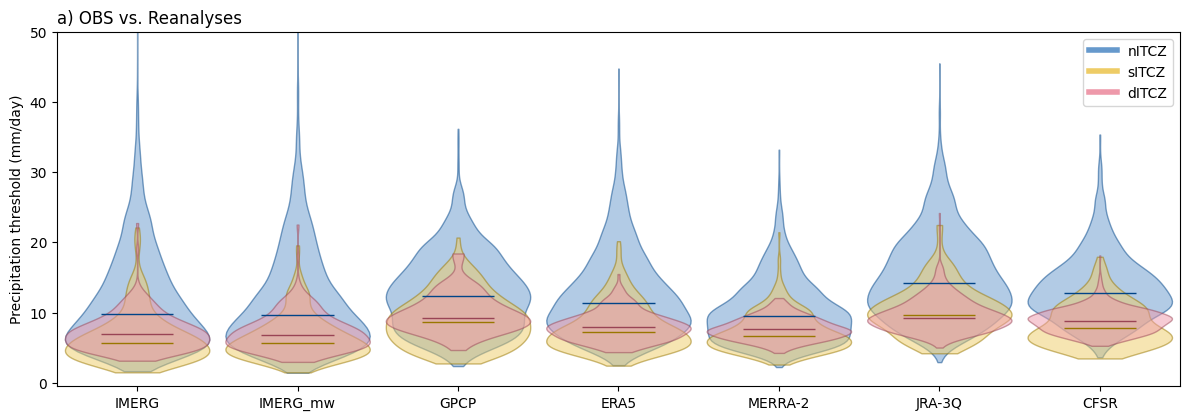

In [13]:
# plot violin plot
npan = 1
from matplotlib.lines import Line2D

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(12, 8), tight_layout='true')
#fig.suptitle(r'Precipitation threshold distribution for '+region_ti+' Ocean ITCZ states ('+mn_str+', '+yr_str+')',fontsize='xx-large')
for jj in range(0,npan,1):
    ax = fig.add_subplot(2,1,jj+1)
    if jj == 0:
        ax1 = ax.violinplot([pr_thresh_nI_tmpa,pr_thresh_nI_imerg,pr_thresh_nI_gpcp,pr_thresh_nI_era5,pr_thresh_nI_merra2,pr_thresh_nI_jra55,pr_thresh_nI_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#6699CC')
            vp.set_edgecolor('#004488')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1) 
        ax1 = ax.violinplot([pr_thresh_sI_tmpa,pr_thresh_sI_imerg,pr_thresh_sI_gpcp,pr_thresh_sI_era5,pr_thresh_sI_merra2,pr_thresh_sI_jra55,pr_thresh_sI_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        for vp in ax1['bodies']:
            vp.set_facecolor('#EECC66')
            vp.set_edgecolor('#997700')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#997700')
        vp.set_linewidth(1) 
        
        ax1 = ax.violinplot([pr_thresh_dI_mean_tmpa,pr_thresh_dI_mean_imerg,pr_thresh_dI_mean_gpcp,pr_thresh_dI_mean_era5,pr_thresh_dI_mean_merra2,pr_thresh_dI_mean_jra55,pr_thresh_dI_mean_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#EE99AA')
            vp.set_edgecolor('#994455')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#994455')
        vp.set_linewidth(1)
            
        ax.set_title('a) OBS vs. Reanalyses', loc='left')
        plt.ylim(-0.5,40)

        #custom_lines = [Line2D([0], [0], color='#6699CC', lw=4),
        #        Line2D([0], [0], color='#EECC66', lw=4),
        #        Line2D([0], [0], color='#EE99AA', lw=4)]

        #ax.legend(custom_lines, ['nITCZ', 'sITCZ', 'dITCZ (max)'])

        custom_lines = [Line2D([0], [0], color='#6699CC', lw=4),
                Line2D([0], [0], color='#EECC66', lw=4),
                Line2D([0], [0], color='#EE99AA', lw=4)]

        ax.legend(custom_lines, ['nITCZ', 'sITCZ', 'dITCZ'])
        
    ax.set_xticks(np.arange(1,8,1), labels=dataset_reana)
    plt.ylim(-0.5,50)
    plt.xlim(0.5,7.5)
    #ax.set_xticks(np.arange(1,7,1), labels=dataset)

    plt.ylabel('Precipitation threshold (mm/day)')
figfolder = '/home/alex.gonzalez/CMIP6_ITCZ_state_project/figures/methods_paper/'
#plt.savefig(figfolder+'ITCZ_state_EastPac_obs_precip_thresh_single_vs_double_FMA.pdf',bbox_inches="tight",transparent=False,dpi=150)

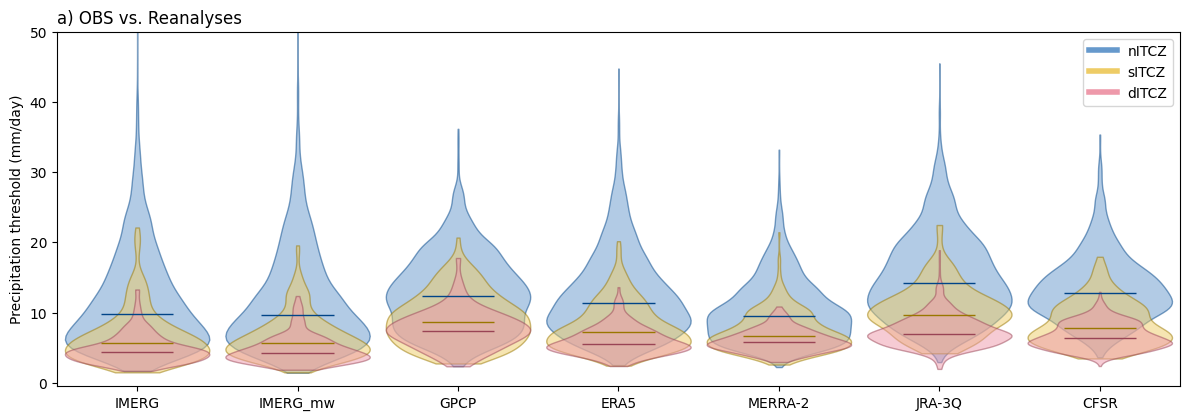

In [14]:
# plot violin plot
npan = 1
from matplotlib.lines import Line2D

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(12, 8), tight_layout='true')
#fig.suptitle(r'Precipitation threshold distribution for '+region_ti+' Ocean ITCZ states ('+mn_str+', '+yr_str+')',fontsize='xx-large')
for jj in range(0,npan,1):
    ax = fig.add_subplot(2,1,jj+1)
    if jj == 0:
        ax1 = ax.violinplot([pr_thresh_nI_tmpa,pr_thresh_nI_imerg,pr_thresh_nI_gpcp,pr_thresh_nI_era5,pr_thresh_nI_merra2,pr_thresh_nI_jra55,pr_thresh_nI_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#6699CC')
            vp.set_edgecolor('#004488')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1) 
        ax1 = ax.violinplot([pr_thresh_sI_tmpa,pr_thresh_sI_imerg,pr_thresh_sI_gpcp,pr_thresh_sI_era5,pr_thresh_sI_merra2,pr_thresh_sI_jra55,pr_thresh_sI_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        for vp in ax1['bodies']:
            vp.set_facecolor('#EECC66')
            vp.set_edgecolor('#997700')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#997700')
        vp.set_linewidth(1) 
        
        ax1 = ax.violinplot([pr_thresh_dI_min_tmpa,pr_thresh_dI_min_imerg,pr_thresh_dI_min_gpcp,pr_thresh_dI_min_era5,pr_thresh_dI_min_merra2,pr_thresh_dI_min_jra55,pr_thresh_dI_min_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#EE99AA')
            vp.set_edgecolor('#994455')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#994455')
        vp.set_linewidth(1)
            
        ax.set_title('a) OBS vs. Reanalyses', loc='left')
        plt.ylim(-0.5,40)

        #custom_lines = [Line2D([0], [0], color='#6699CC', lw=4),
        #        Line2D([0], [0], color='#EECC66', lw=4),
        #        Line2D([0], [0], color='#EE99AA', lw=4)]

        #ax.legend(custom_lines, ['nITCZ', 'sITCZ', 'dITCZ (max)'])

        custom_lines = [Line2D([0], [0], color='#6699CC', lw=4),
                Line2D([0], [0], color='#EECC66', lw=4),
                Line2D([0], [0], color='#EE99AA', lw=4)]

        ax.legend(custom_lines, ['nITCZ', 'sITCZ', 'dITCZ'])
        
    ax.set_xticks(np.arange(1,8,1), labels=dataset_reana)
    plt.ylim(-0.5,50)
    plt.xlim(0.5,7.5)
    #ax.set_xticks(np.arange(1,7,1), labels=dataset)

    plt.ylabel('Precipitation threshold (mm/day)')
figfolder = '/home/alex.gonzalez/CMIP6_ITCZ_state_project/figures/methods_paper/'
#plt.savefig(figfolder+'ITCZ_state_EastPac_obs_precip_thresh_single_vs_double_FMA.pdf',bbox_inches="tight",transparent=False,dpi=150)

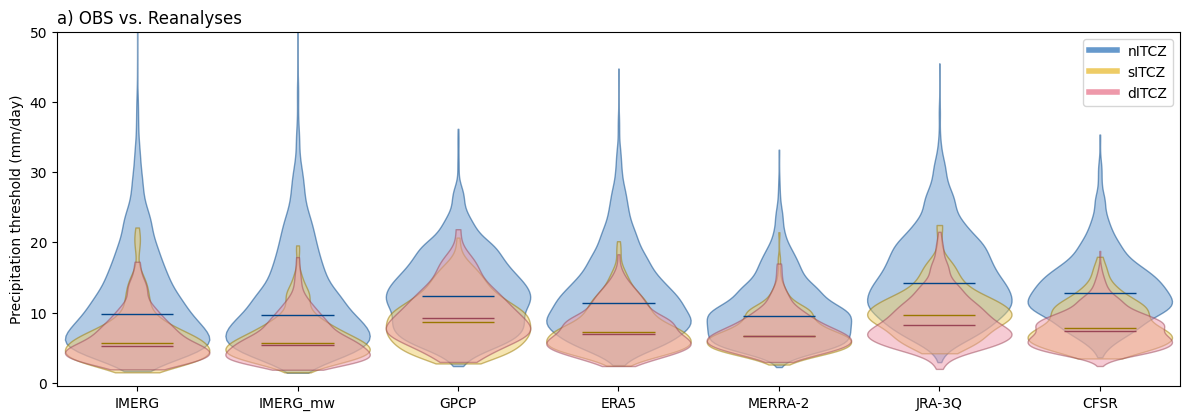

In [15]:
# plot violin plot
npan = 1
from matplotlib.lines import Line2D

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(12, 8), tight_layout='true')
#fig.suptitle(r'Precipitation threshold distribution for '+region_ti+' Ocean ITCZ states ('+mn_str+', '+yr_str+')',fontsize='xx-large')
for jj in range(0,npan,1):
    ax = fig.add_subplot(2,1,jj+1)
    if jj == 0:
        ax1 = ax.violinplot([pr_thresh_nI_tmpa,pr_thresh_nI_imerg,pr_thresh_nI_gpcp,pr_thresh_nI_era5,pr_thresh_nI_merra2,pr_thresh_nI_jra55,pr_thresh_nI_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#6699CC')
            vp.set_edgecolor('#004488')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1) 
        ax1 = ax.violinplot([pr_thresh_sI_tmpa,pr_thresh_sI_imerg,pr_thresh_sI_gpcp,pr_thresh_sI_era5,pr_thresh_sI_merra2,pr_thresh_sI_jra55,pr_thresh_sI_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        for vp in ax1['bodies']:
            vp.set_facecolor('#EECC66')
            vp.set_edgecolor('#997700')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#997700')
        vp.set_linewidth(1) 
        
        ax1 = ax.violinplot([pr_thresh_dI_SH_tmpa,pr_thresh_dI_SH_imerg,pr_thresh_dI_SH_gpcp,pr_thresh_dI_SH_era5,pr_thresh_dI_SH_merra2,pr_thresh_dI_SH_jra55,pr_thresh_dI_SH_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#EE99AA')
            vp.set_edgecolor('#994455')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#994455')
        vp.set_linewidth(1)
            
        ax.set_title('a) OBS vs. Reanalyses', loc='left')
        plt.ylim(-0.5,40)

        #custom_lines = [Line2D([0], [0], color='#6699CC', lw=4),
        #        Line2D([0], [0], color='#EECC66', lw=4),
        #        Line2D([0], [0], color='#EE99AA', lw=4)]

        #ax.legend(custom_lines, ['nITCZ', 'sITCZ', 'dITCZ (max)'])

        custom_lines = [Line2D([0], [0], color='#6699CC', lw=4),
                Line2D([0], [0], color='#EECC66', lw=4),
                Line2D([0], [0], color='#EE99AA', lw=4)]

        ax.legend(custom_lines, ['nITCZ', 'sITCZ', 'dITCZ'])
        
    ax.set_xticks(np.arange(1,8,1), labels=dataset_reana)
    plt.ylim(-0.5,50)
    plt.xlim(0.5,7.5)
    #ax.set_xticks(np.arange(1,7,1), labels=dataset)

    plt.ylabel('Precipitation threshold (mm/day)')
figfolder = '/home/alex.gonzalez/CMIP6_ITCZ_state_project/figures/methods_paper/'
#plt.savefig(figfolder+'ITCZ_state_EastPac_obs_precip_thresh_single_vs_double_FMA.pdf',bbox_inches="tight",transparent=False,dpi=150)

In [16]:
# Now run the code for CMIP6 models

In [17]:
dataset_CMIP = ['BCC-CSM2-MR',
            'CAMS-CSM1-0',
            'CESM2',
            'CESM2-WACCM',
            'CMCC-CM2-HR4',
            'CMCC-CM2-SR5',
            'CMCC-ESM2',
            'CNRM-CM6-1-HR',
            'E3SM-1-0', #
            'E3SM-2-0',#
            'E3SM-2-0-NARRM',#
            'EC-Earth3',#
            'EC-Earth3-AerChem',#
            'EC-Earth3-CC',#
            'EC-Earth3-Veg',#
            'EC-Earth3-Veg-LR',#
            'FGOALS-f3-L',#
            'GFDL-CM4',#
            'GFDL-ESM4',#
            'HadGEM3-GC31-MM',
            'MPI-ESM1-2-HR',#
            'MRI-ESM2-0',#
            'NorESM2-MM',
            'SAM0-UNICON',
            'TaiESM1']

In [18]:
datasets_CMIP_xr = xr.DataArray(dataset_CMIP, coords=[dataset_CMIP], dims=['dataset'])

ndatasetc = len(dataset_CMIP)
ndatasetc

25

In [19]:
flds = np.empty((ndatasetc),dtype=object)
fn_its = np.empty((ndatasetc),dtype=object)
for jj in range(0,ndatasetc,1):
    flds[jj] = '/srv/lss/CMIP6_precip_1deg/'+dataset_CMIP[jj]+'/'
    fn_its[jj] = dataset_CMIP[jj]+'_ITCZ_st_daily_'+region_fn+'_abs_thresh.nc'

flds_xr = xr.DataArray(flds, coords=[dataset_CMIP], dims=['dataset'])
fn_its_xr = xr.DataArray(fn_its, coords=[dataset_CMIP], dims=['dataset'])

In [20]:
yr0 = 1980
yrf = 2014

In [21]:
# BCC
fld_sel = flds_xr.sel(dataset='BCC-CSM2-MR').values
fn_sel = fn_its_xr.sel(dataset='BCC-CSM2-MR').values
[pr_thresh_dI_mean_bcc, pr_thresh_dI_max_bcc, pr_thresh_dI_min_bcc, pr_thresh_dI_NH_bcc, pr_thresh_dI_SH_bcc, pr_thresh_sI_bcc, pr_thresh_nI_bcc, prc_dITCZ_bcc, prc_nITCZ_bcc] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 2.3651844843897827
dITCZs: 27.60643330179754
sITCZs: 46.49006622516556
Panel with sITCZs and dITCZs


In [22]:
# 'CAMS'
fld_sel = flds_xr.sel(dataset='CAMS-CSM1-0').values
fn_sel = fn_its_xr.sel(dataset='CAMS-CSM1-0').values
[pr_thresh_dI_mean_cams, pr_thresh_dI_max_cams, pr_thresh_dI_min_cams, pr_thresh_dI_NH_cams, pr_thresh_dI_SH_cams, pr_thresh_sI_cams, pr_thresh_nI_cams, prc_dITCZ_cams, prc_nITCZ_cams] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 4.8734416320362675
dITCZs: 12.80695126558368
sITCZs: 58.17907064601435
Panel with sITCZs and dITCZs


In [23]:
# 'CESM2'
fld_sel = flds_xr.sel(dataset='CESM2').values
fn_sel = fn_its_xr.sel(dataset='CESM2').values
[pr_thresh_dI_mean_CESM2, pr_thresh_dI_max_CESM2, pr_thresh_dI_min_CESM2, pr_thresh_dI_NH_CESM2, pr_thresh_dI_SH_CESM2, pr_thresh_sI_CESM2, pr_thresh_nI_CESM2, prc_dITCZ_CESM2, prc_nITCZ_CESM2] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 44.91958372753075
dITCZs: 2.327341532639546
sITCZs: 13.528855250709556
Panel with sITCZs and nITCZs


In [24]:
# 'CESM2-WACCM'
fld_sel = flds_xr.sel(dataset='CESM2-WACCM').values
fn_sel = fn_its_xr.sel(dataset='CESM2-WACCM').values
[pr_thresh_dI_mean_CESM2W, pr_thresh_dI_max_CESM2W, pr_thresh_dI_min_CESM2W, pr_thresh_dI_NH_CESM2W, pr_thresh_dI_SH_CESM2W, pr_thresh_sI_CESM2W, pr_thresh_nI_CESM2W, prc_dITCZ_CESM2W, prc_nITCZ_CESM2W] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 63.897824030274364
dITCZs: 0.510879848628193
sITCZs: 4.446546830652791
Panel with sITCZs and nITCZs


In [25]:
# CMCC-CM2-HR4
fld_sel = flds_xr.sel(dataset='CMCC-CM2-HR4').values
fn_sel = fn_its_xr.sel(dataset='CMCC-CM2-HR4').values
[pr_thresh_dI_mean_CMCCH, pr_thresh_dI_max_CMCCH, pr_thresh_dI_min_CMCCH, pr_thresh_dI_NH_CMCCH, pr_thresh_dI_SH_CMCCH, pr_thresh_sI_CMCCH, pr_thresh_nI_CMCCH, prc_dITCZ_CMCCH, prc_nITCZ_CMCCH] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 2.9517502365184485
dITCZs: 6.830652790917692
sITCZs: 68.53358561967833
Panel with sITCZs and dITCZs


In [26]:
# CMCC-CM2-SR5
fld_sel = flds_xr.sel(dataset='CMCC-CM2-SR5').values
fn_sel = fn_its_xr.sel(dataset='CMCC-CM2-SR5').values
[pr_thresh_dI_mean_CMCCS, pr_thresh_dI_max_CMCCS, pr_thresh_dI_min_CMCCS, pr_thresh_dI_NH_CMCCS, pr_thresh_dI_SH_CMCCS, pr_thresh_sI_CMCCS, pr_thresh_nI_CMCCS, prc_dITCZ_CMCCS, prc_nITCZ_CMCCS] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 18.126773888363292
dITCZs: 20.775780510879848
sITCZs: 30.085146641438033
Panel with sITCZs and dITCZs


In [27]:
# CMCC-ESM2
fld_sel = flds_xr.sel(dataset='CMCC-ESM2').values
fn_sel = fn_its_xr.sel(dataset='CMCC-ESM2').values
[pr_thresh_dI_mean_CMCCE, pr_thresh_dI_max_CMCCE, pr_thresh_dI_min_CMCCE, pr_thresh_dI_NH_CMCCE, pr_thresh_dI_SH_CMCCE, pr_thresh_sI_CMCCE, pr_thresh_nI_CMCCE, prc_dITCZ_CMCCE, prc_nITCZ_CMCCE] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 22.91390728476821
dITCZs: 24.919583727530746
sITCZs: 22.3841059602649
Panel with all


In [28]:
# CNRM-CM6-1-HR
fld_sel = flds_xr.sel(dataset='CNRM-CM6-1-HR').values
fn_sel = fn_its_xr.sel(dataset='CNRM-CM6-1-HR').values
[pr_thresh_dI_mean_CNRM, pr_thresh_dI_max_CNRM, pr_thresh_dI_min_CNRM, pr_thresh_dI_NH_CNRM, pr_thresh_dI_SH_CNRM, pr_thresh_sI_CNRM, pr_thresh_nI_CNRM, prc_dITCZ_CNRM, prc_nITCZ_CNRM] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 3.8345296562145825
dITCZs: 65.35700793350964
sITCZs: 4.174537211938043
Panel with sITCZs and dITCZs


In [29]:
# E3SM-1-0
fld_sel = flds_xr.sel(dataset='E3SM-1-0').values
fn_sel = fn_its_xr.sel(dataset='E3SM-1-0').values
[pr_thresh_dI_mean_E3SM1, pr_thresh_dI_max_E3SM1, pr_thresh_dI_min_E3SM1, pr_thresh_dI_NH_E3SM1, pr_thresh_dI_SH_E3SM1, pr_thresh_sI_E3SM1, pr_thresh_nI_E3SM1, prc_dITCZ_E3SM1, prc_nITCZ_E3SM1] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 15.137180700094607
dITCZs: 12.034058656575212
sITCZs: 47.984862819299906
Panel with sITCZs and dITCZs


In [30]:
# E3SM-2-0
fld_sel = flds_xr.sel(dataset='E3SM-2-0').values
fn_sel = fn_its_xr.sel(dataset='E3SM-2-0').values
[pr_thresh_dI_mean_E3SM2, pr_thresh_dI_max_E3SM2, pr_thresh_dI_min_E3SM2, pr_thresh_dI_NH_E3SM2, pr_thresh_dI_SH_E3SM2, pr_thresh_sI_E3SM2, pr_thresh_nI_E3SM2, prc_dITCZ_E3SM2, prc_nITCZ_E3SM2] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 25.657521286660362
dITCZs: 3.6707663197729423
sITCZs: 25.808893093661307
Panel with all


In [31]:
# E3SM-2-0-NARRM
fld_sel = flds_xr.sel(dataset='E3SM-2-0-NARRM').values
fn_sel = fn_its_xr.sel(dataset='E3SM-2-0-NARRM').values
[pr_thresh_dI_mean_E3SM2N, pr_thresh_dI_max_E3SM2N, pr_thresh_dI_min_E3SM2N, pr_thresh_dI_NH_E3SM2N, pr_thresh_dI_SH_E3SM2N, pr_thresh_sI_E3SM2N, pr_thresh_nI_E3SM2N, prc_dITCZ_E3SM2N, prc_nITCZ_E3SM2N] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 17.880794701986755
dITCZs: 4.768211920529802
sITCZs: 34.17218543046358
Panel with sITCZs and dITCZs


In [32]:
# 'EC-Earth3'
fld_sel = flds_xr.sel(dataset='EC-Earth3').values
fn_sel = fn_its_xr.sel(dataset='EC-Earth3').values
[pr_thresh_dI_mean_ECEarth3, pr_thresh_dI_max_ECEarth3, pr_thresh_dI_min_ECEarth3, pr_thresh_dI_NH_ECEarth3, pr_thresh_dI_SH_ECEarth3, pr_thresh_sI_ECEarth3, pr_thresh_nI_ECEarth3, prc_dITCZ_ECEarth3, prc_nITCZ_ECEarth3] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 10.181337363052512
dITCZs: 7.895731016244806
sITCZs: 59.42576501700037
Panel with sITCZs and dITCZs


In [33]:
# 'EC-Earth3-AerChem'
fld_sel = flds_xr.sel(dataset='EC-Earth3-AerChem').values
fn_sel = fn_its_xr.sel(dataset='EC-Earth3-AerChem').values
[pr_thresh_dI_mean_ECEarth3A, pr_thresh_dI_max_ECEarth3A, pr_thresh_dI_min_ECEarth3A, pr_thresh_dI_NH_ECEarth3A, pr_thresh_dI_SH_ECEarth3A, pr_thresh_sI_ECEarth3A, pr_thresh_nI_ECEarth3A, prc_dITCZ_ECEarth3A, prc_nITCZ_ECEarth3A] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 9.576879486210805
dITCZs: 8.65130336229694
sITCZs: 62.051378919531544
Panel with sITCZs and dITCZs


In [34]:
# 'EC-Earth3-CC'
fld_sel = flds_xr.sel(dataset='EC-Earth3-CC').values
fn_sel = fn_its_xr.sel(dataset='EC-Earth3-CC').values
[pr_thresh_dI_mean_ECEarth3C, pr_thresh_dI_max_ECEarth3C, pr_thresh_dI_min_ECEarth3C, pr_thresh_dI_NH_ECEarth3C, pr_thresh_dI_SH_ECEarth3C, pr_thresh_sI_ECEarth3C, pr_thresh_nI_ECEarth3C, prc_dITCZ_ECEarth3C, prc_nITCZ_ECEarth3C] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 9.595768794862108
dITCZs: 8.330185115224783
sITCZs: 59.25576123913865
Panel with sITCZs and dITCZs


In [35]:
# 'EC-Earth3-Veg'
fld_sel = flds_xr.sel(dataset='EC-Earth3-Veg').values
fn_sel = fn_its_xr.sel(dataset='EC-Earth3-Veg').values
[pr_thresh_dI_mean_ECEarth3V, pr_thresh_dI_max_ECEarth3V, pr_thresh_dI_min_ECEarth3V, pr_thresh_dI_NH_ECEarth3V, pr_thresh_dI_SH_ECEarth3V, pr_thresh_sI_ECEarth3V, pr_thresh_nI_ECEarth3V, prc_dITCZ_ECEarth3V, prc_nITCZ_ECEarth3V] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 10.068001511144692
dITCZs: 7.234605213449188
sITCZs: 59.87910842463165
Panel with sITCZs and dITCZs


In [36]:
# 'EC-Earth3-Veg-LR'
fld_sel = flds_xr.sel(dataset='EC-Earth3-Veg-LR').values
fn_sel = fn_its_xr.sel(dataset='EC-Earth3-Veg-LR').values
[pr_thresh_dI_mean_ECEarth3VL, pr_thresh_dI_max_ECEarth3VL, pr_thresh_dI_min_ECEarth3VL, pr_thresh_dI_NH_ECEarth3VL, pr_thresh_dI_SH_ECEarth3VL, pr_thresh_sI_ECEarth3VL, pr_thresh_nI_ECEarth3VL, prc_dITCZ_ECEarth3VL, prc_nITCZ_ECEarth3VL] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 6.762372497166604
dITCZs: 8.87797506611258
sITCZs: 63.92142047601058
Panel with sITCZs and dITCZs


In [37]:
# 'FGOALS-f3-L'
fld_sel = flds_xr.sel(dataset='FGOALS-f3-L').values
fn_sel = fn_its_xr.sel(dataset='FGOALS-f3-L').values
[pr_thresh_dI_mean_FGOALS, pr_thresh_dI_max_FGOALS, pr_thresh_dI_min_FGOALS, pr_thresh_dI_NH_FGOALS, pr_thresh_dI_SH_FGOALS, pr_thresh_sI_FGOALS, pr_thresh_nI_FGOALS, prc_dITCZ_FGOALS, prc_nITCZ_FGOALS] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 33.03689687795648
dITCZs: 3.084200567644276
sITCZs: 13.2639545884579
Panel with all


In [38]:
# 'GFDL-CM4'
fld_sel = flds_xr.sel(dataset='GFDL-CM4').values
fn_sel = fn_its_xr.sel(dataset='GFDL-CM4').values
[pr_thresh_dI_mean_GFDLC, pr_thresh_dI_max_GFDLC, pr_thresh_dI_min_GFDLC, pr_thresh_dI_NH_GFDLC, pr_thresh_dI_SH_GFDLC, pr_thresh_sI_GFDLC, pr_thresh_nI_GFDLC, prc_dITCZ_GFDLC, prc_nITCZ_GFDLC] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 27.587511825922423
dITCZs: 4.143803216650898
sITCZs: 41.3434247871334
Panel with all


In [39]:
# 'GFDL-ESM4'
fld_sel = flds_xr.sel(dataset='GFDL-ESM4').values
fn_sel = fn_its_xr.sel(dataset='GFDL-ESM4').values
[pr_thresh_dI_mean_GFDLE, pr_thresh_dI_max_GFDLE, pr_thresh_dI_min_GFDLE, pr_thresh_dI_NH_GFDLE, pr_thresh_dI_SH_GFDLE, pr_thresh_sI_GFDLE, pr_thresh_nI_GFDLE, prc_dITCZ_GFDLE, prc_nITCZ_GFDLE] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 16.7833491012299
dITCZs: 4.1816461684011355
sITCZs: 59.54588457899717
Panel with sITCZs and dITCZs


In [40]:
# HadGEM3-GC31-MM

fld_sel = flds_xr.sel(dataset='HadGEM3-GC31-MM').values
fn_sel = fn_its_xr.sel(dataset='HadGEM3-GC31-MM').values
[pr_thresh_dI_mean_Had, pr_thresh_dI_max_Had, pr_thresh_dI_min_Had, pr_thresh_dI_NH_Had, pr_thresh_dI_SH_Had, pr_thresh_sI_Had, pr_thresh_nI_Had, prc_dITCZ_Had, prc_nITCZ_Had] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 33.695238095238096
dITCZs: 8.552380952380952
sITCZs: 12.857142857142856
Panel with all


In [41]:
# 'MPI-ESM1-2-HR'

fld_sel = flds_xr.sel(dataset='MPI-ESM1-2-HR').values
fn_sel = fn_its_xr.sel(dataset='MPI-ESM1-2-HR').values
[pr_thresh_dI_mean_MPI, pr_thresh_dI_max_MPI, pr_thresh_dI_min_MPI, pr_thresh_dI_NH_MPI, pr_thresh_dI_SH_MPI, pr_thresh_sI_MPI, pr_thresh_nI_MPI, prc_dITCZ_MPI, prc_nITCZ_MPI] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 20.438231960710237
dITCZs: 11.994710993577636
sITCZs: 40.00755572346052
Panel with sITCZs and dITCZs


In [42]:
# 'MRI-ESM2-0'

fld_sel = flds_xr.sel(dataset='MRI-ESM2-0').values
fn_sel = fn_its_xr.sel(dataset='MRI-ESM2-0').values
[pr_thresh_dI_mean_MRI, pr_thresh_dI_max_MRI, pr_thresh_dI_min_MRI, pr_thresh_dI_NH_MRI, pr_thresh_dI_SH_MRI, pr_thresh_sI_MRI, pr_thresh_nI_MRI, prc_dITCZ_MRI, prc_nITCZ_MRI] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 29.788439743105403
dITCZs: 7.650170003777862
sITCZs: 35.05855685681904
Panel with all


In [43]:
# NorESM2-MM

fld_sel = flds_xr.sel(dataset='NorESM2-MM').values
fn_sel = fn_its_xr.sel(dataset='NorESM2-MM').values
[pr_thresh_dI_mean_Nor, pr_thresh_dI_max_Nor, pr_thresh_dI_min_Nor, pr_thresh_dI_NH_Nor, pr_thresh_dI_SH_Nor, pr_thresh_sI_Nor, pr_thresh_nI_Nor, prc_dITCZ_Nor, prc_nITCZ_Nor] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 56.76442762535478
dITCZs: 8.571428571428571
sITCZs: 7.530747398297068
Panel with all


In [44]:
# SAM0-UNICON

fld_sel = flds_xr.sel(dataset='SAM0-UNICON').values
fn_sel = fn_its_xr.sel(dataset='SAM0-UNICON').values
[pr_thresh_dI_mean_SAM, pr_thresh_dI_max_SAM, pr_thresh_dI_min_SAM, pr_thresh_dI_NH_SAM, pr_thresh_dI_SH_SAM, pr_thresh_sI_SAM, pr_thresh_nI_SAM, prc_dITCZ_SAM, prc_nITCZ_SAM] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 43.084200567644274
dITCZs: 20.22705771050142
sITCZs: 13.945127719962159
Panel with all


In [45]:
# TaiESM1

fld_sel = flds_xr.sel(dataset='TaiESM1').values
fn_sel = fn_its_xr.sel(dataset='TaiESM1').values
[pr_thresh_dI_mean_Tai, pr_thresh_dI_max_Tai, pr_thresh_dI_min_Tai, pr_thresh_dI_NH_Tai, pr_thresh_dI_SH_Tai, pr_thresh_sI_Tai, pr_thresh_nI_Tai, prc_dITCZ_Tai, prc_nITCZ_Tai] = compute_pr_thresh(fld_sel,fn_sel,yr0,yrf)

nITCZs: 17.29422894985809
dITCZs: 17.69157994323557
sITCZs: 32.16650898770104
Panel with sITCZs and dITCZs


In [46]:
# models with significant nITCZs (n=11)
# all – CESM2, CESM2-W, CMCC-ESM2, E3SM-2-0, # 'FGOALS-f3-L', 
# 'GFDL-CM4', # HadGEM3-GC31-MM, # 'MPI-ESM1-2-HR', 'MRI-ESM2-0', # NorESM2-MM, SAM
# n and s – CESM2 and CESM2-WACCM

In [47]:
# models without nITCZs (n=14, only show 11)
# Leave out 3 EC-Earths
# 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'CNRM-CM6-1-HR',
#       'E3SM-1-0', 'E3SM-2-0-NARRM', 'EC-Earth3', 'EC-Earth3-Veg-LR'  'GFDL-ESM4', 'TaiESM1'

In [48]:
dataset_reana_plt = dataset_reana
dataset_reana_plt[0] = 'IMERG (MW+IR)'
dataset_reana_plt[1] = 'IMERG (MW)'

In [49]:
pr_thresh_plt1_names = ['IMERG (MW+IR)',r'CESM2',r'CESM2-WACCM$^T$','CMCC-ESM2','E3SM-2-0','FGOALS-f3-L', \
                        'GFDL-CM4','HadGEM3','MPI-ESM1-2-HR','MRI-ESM2-0',r'NorESM2-MM$^T$','SAM0-UNICON']
pr_thresh_plt2_names = ['IMERG (MW+IR)','BCC-CSM2-MR', 'CAMS-CSM1-0', 'CMCC-CM2-HR4','CMCC-CM2-SR5', 'CNRM-CM6-1-HR', \
                         'E3SM-1-0', 'E3SM-2-0-NARRM', 'EC-Earth3', 'EC-Earth3-Veg-LR', 'GFDL-ESM4', 'TaiESM1']

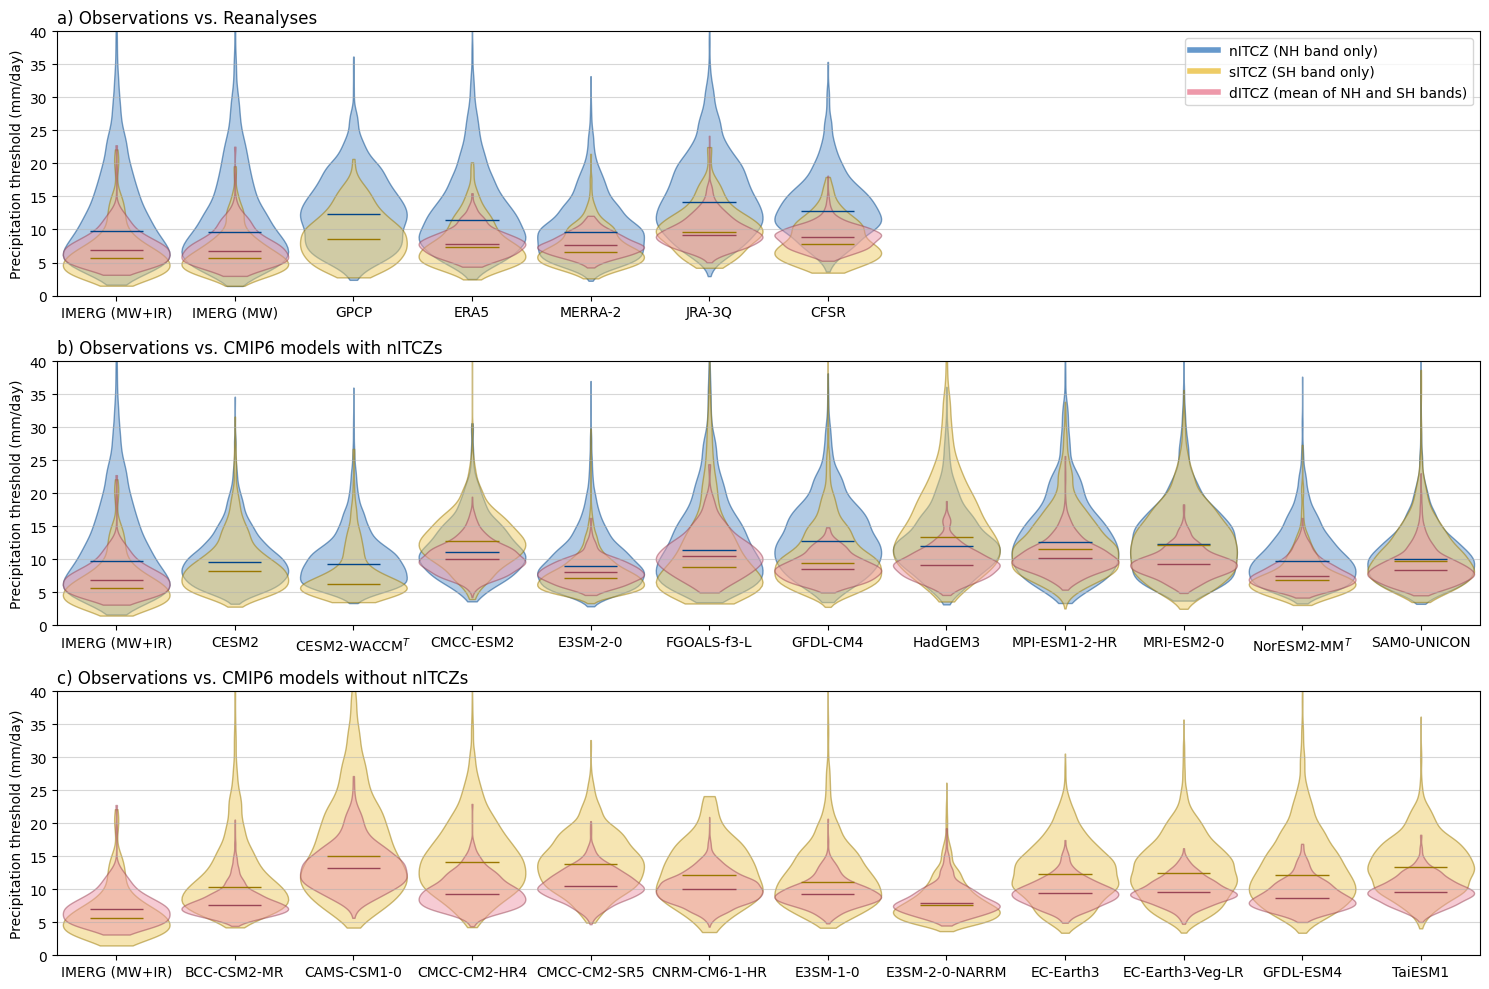

In [50]:
# plot violin plot
npan = 3
from matplotlib.lines import Line2D

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(15, 10), tight_layout='true')
#fig.suptitle(r'Precipitation threshold distribution for '+region_ti+' Ocean ITCZ states ('+mn_str+', '+yr_str+')',fontsize='xx-large')
for jj in range(0,npan,1):
    ax = fig.add_subplot(npan,1,jj+1)
    plt.ylim(0,40)
    if jj == 0:
        ax1 = ax.violinplot([pr_thresh_nI_tmpa,pr_thresh_nI_imerg,pr_thresh_nI_gpcp,pr_thresh_nI_era5,pr_thresh_nI_merra2,pr_thresh_nI_jra55,pr_thresh_nI_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#6699CC')
            vp.set_edgecolor('#004488')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1) 
        ax1 = ax.violinplot([pr_thresh_sI_tmpa,pr_thresh_sI_imerg,pr_thresh_sI_gpcp,pr_thresh_sI_era5,pr_thresh_sI_merra2,pr_thresh_sI_jra55,pr_thresh_sI_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        for vp in ax1['bodies']:
            vp.set_facecolor('#EECC66')
            vp.set_edgecolor('#997700')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#997700')
        vp.set_linewidth(1) 

        ax1 = ax.violinplot([pr_thresh_dI_mean_tmpa,pr_thresh_dI_mean_imerg,pr_thresh_dI_mean_gpcp*-9999,pr_thresh_dI_mean_era5,pr_thresh_dI_mean_merra2,pr_thresh_dI_mean_jra55,pr_thresh_dI_mean_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#EE99AA')
            vp.set_edgecolor('#994455')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#994455')
        vp.set_linewidth(1)
            
        ax.set_title('a) Observations vs. Reanalyses', loc='left')
        ax.set_xticks(np.arange(1,8,1), labels=dataset_reana_plt)
        plt.xlim(0.5,12.5)
    #ax.set_xticks(np.arange(1,7,1), labels=dataset)
    
        custom_lines = [Line2D([0], [0], color='#6699CC', lw=4),
                Line2D([0], [0], color='#EECC66', lw=4),
                Line2D([0], [0], color='#EE99AA', lw=4)]

        ax.legend(custom_lines, ['nITCZ (NH band only)', 'sITCZ (SH band only)', 'dITCZ (mean of NH and SH bands)'])
    if jj == 1:
        ax1 = ax.violinplot([pr_thresh_nI_tmpa,pr_thresh_nI_CESM2,pr_thresh_nI_CESM2W,pr_thresh_nI_CMCCE, pr_thresh_nI_E3SM2, \
                             pr_thresh_nI_FGOALS,pr_thresh_nI_GFDLC,pr_thresh_nI_Had,pr_thresh_nI_MPI, pr_thresh_nI_MRI, \
                             pr_thresh_nI_Nor,pr_thresh_nI_SAM],
                             showmeans=False,showmedians=True,showextrema=False,widths=0.9)
        
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#6699CC')
            vp.set_edgecolor('#004488')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1) 
        
        ax1 = ax.violinplot([pr_thresh_sI_tmpa,pr_thresh_sI_CESM2,pr_thresh_sI_CESM2W,pr_thresh_sI_CMCCE, pr_thresh_sI_E3SM2, \
                             pr_thresh_sI_FGOALS,pr_thresh_sI_GFDLC,pr_thresh_sI_Had,pr_thresh_sI_MPI, pr_thresh_sI_MRI, \
                             pr_thresh_sI_Nor,pr_thresh_sI_SAM],
                             showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        for vp in ax1['bodies']:
            vp.set_facecolor('#EECC66')
            vp.set_edgecolor('#997700')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#997700')
        vp.set_linewidth(1) 
        ax1 = ax.violinplot([pr_thresh_dI_mean_tmpa,pr_thresh_dI_mean_CESM2*-9999,pr_thresh_dI_mean_CESM2W*-9999, \
                             pr_thresh_dI_mean_CMCCE,pr_thresh_dI_mean_E3SM2, pr_thresh_dI_mean_FGOALS,\
                             pr_thresh_dI_mean_GFDLC, pr_thresh_dI_mean_Had,\
                             pr_thresh_dI_mean_MPI, pr_thresh_dI_mean_MRI, \
                             pr_thresh_dI_mean_Nor,pr_thresh_dI_mean_SAM],
                             showmeans=False,showmedians=True,showextrema=False,widths=0.9)
        
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#EE99AA')
            vp.set_edgecolor('#994455')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#994455')
        vp.set_linewidth(1)
            
        ax.set_title('b) Observations vs. CMIP6 models with nITCZs', loc='left')

        custom_lines = [Line2D([0], [0], color='#6699CC', lw=4),
                Line2D([0], [0], color='#EECC66', lw=4),
                Line2D([0], [0], color='#EE99AA', lw=4)]
        #ax.legend(custom_lines, ['nITCZ (NH band only, Feb-Apr)', 'sITCZ (SH band only, Feb-Apr)', 'dITCZ (mean of NH and SH bands, Jan–May)'])

        ax.set_xticks(np.arange(1,13,1), labels=pr_thresh_plt1_names)
        plt.xlim(0.5,12.5)
    if jj == 2:
        ax1 = ax.violinplot([pr_thresh_sI_tmpa,pr_thresh_sI_bcc,pr_thresh_sI_cams,pr_thresh_sI_CMCCH, \
                             pr_thresh_sI_CMCCS, pr_thresh_sI_CNRM,pr_thresh_sI_E3SM1,pr_thresh_sI_E3SM2N, \
                             pr_thresh_sI_ECEarth3,pr_thresh_sI_ECEarth3VL, pr_thresh_sI_GFDLE, pr_thresh_sI_Tai],
                             showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        for vp in ax1['bodies']:
            vp.set_facecolor('#EECC66')
            vp.set_edgecolor('#997700')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#997700')
        vp.set_linewidth(1) 
        
        ax1 = ax.violinplot([pr_thresh_dI_mean_tmpa,pr_thresh_dI_mean_bcc,pr_thresh_dI_mean_cams, \
                             pr_thresh_dI_mean_CMCCH,pr_thresh_dI_mean_CMCCS,pr_thresh_dI_mean_CNRM, \
                             pr_thresh_dI_mean_E3SM1,pr_thresh_dI_mean_E3SM2N,pr_thresh_dI_mean_ECEarth3, \
                             pr_thresh_dI_mean_ECEarth3VL,pr_thresh_dI_mean_GFDLE,pr_thresh_dI_mean_Tai],
                             showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#EE99AA')
            vp.set_edgecolor('#994455')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#994455')
        vp.set_linewidth(1)

        ax.set_title('c) Observations vs. CMIP6 models without nITCZs', loc='left')
        ax.set_xticks(np.arange(1,13,1), labels=pr_thresh_plt2_names)
        plt.xlim(0.5,12.5)

    ax.yaxis.grid(alpha=0.5,zorder=-1)

    plt.ylabel('Precipitation threshold (mm/day)')

#plt.savefig(figfolder+'ITCZ_state_EastPac_precip_thresh_Jan-May.pdf',bbox_inches="tight",transparent=False,dpi=150)

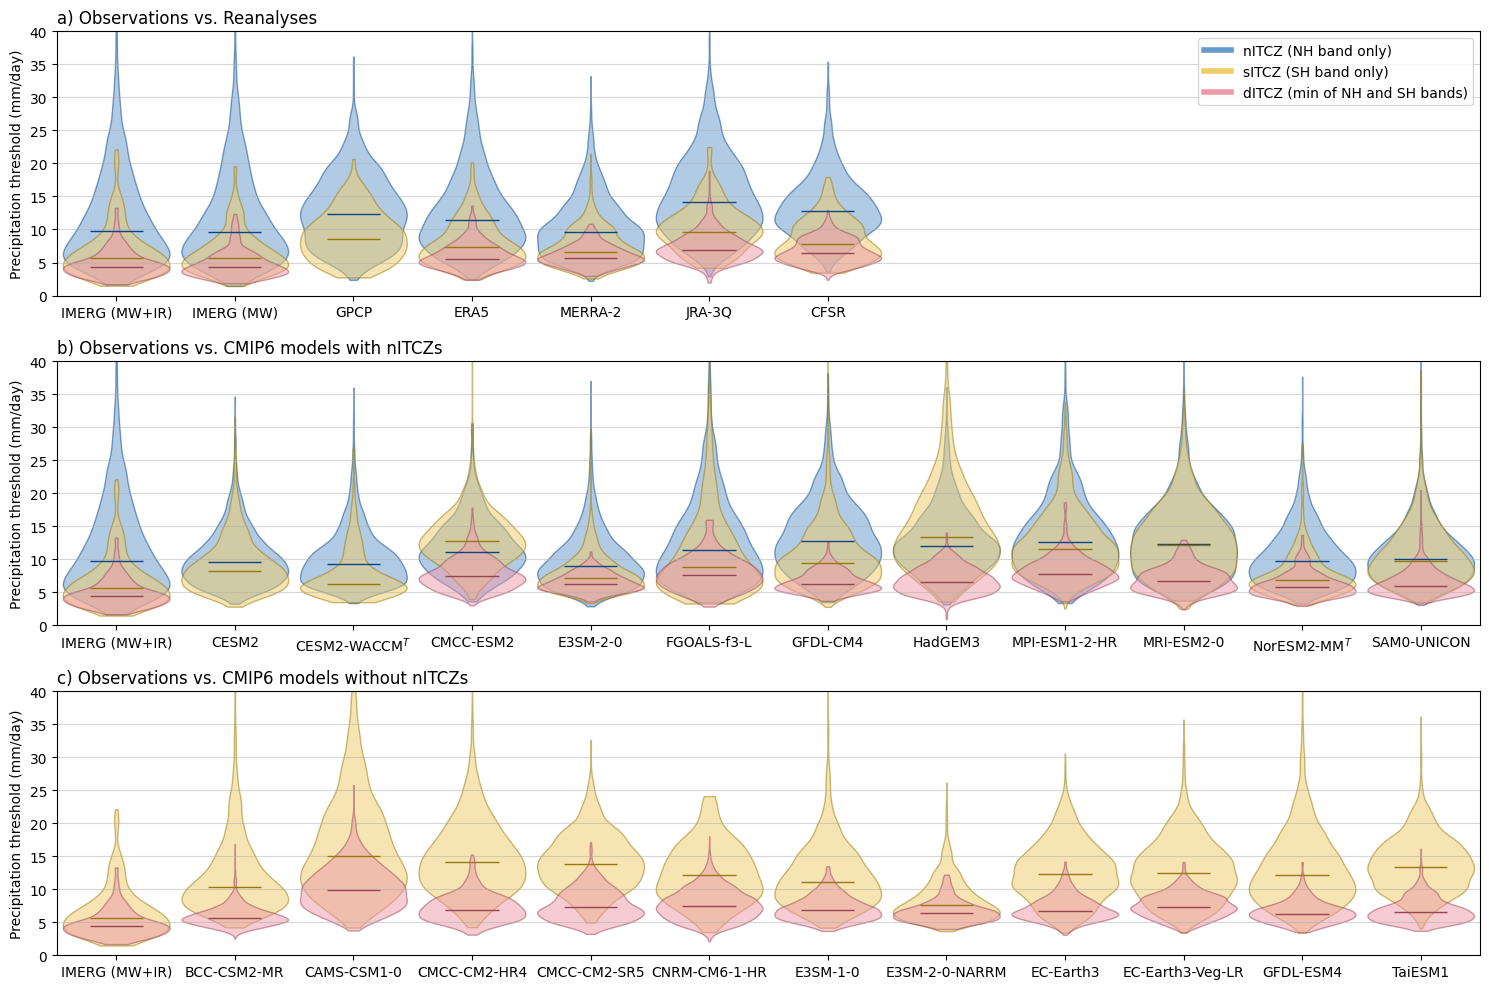

In [51]:
# plot violin plot
npan = 3
from matplotlib.lines import Line2D

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(15, 10), tight_layout='true')
#fig.suptitle(r'Precipitation threshold distribution for '+region_ti+' Ocean ITCZ states ('+mn_str+', '+yr_str+')',fontsize='xx-large')
for jj in range(0,npan,1):
    ax = fig.add_subplot(npan,1,jj+1)
    plt.ylim(0,40)
    if jj == 0:
        ax1 = ax.violinplot([pr_thresh_nI_tmpa,pr_thresh_nI_imerg,pr_thresh_nI_gpcp,pr_thresh_nI_era5,pr_thresh_nI_merra2,pr_thresh_nI_jra55,pr_thresh_nI_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#6699CC')
            vp.set_edgecolor('#004488')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1) 
        ax1 = ax.violinplot([pr_thresh_sI_tmpa,pr_thresh_sI_imerg,pr_thresh_sI_gpcp,pr_thresh_sI_era5,pr_thresh_sI_merra2,pr_thresh_sI_jra55,pr_thresh_sI_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        for vp in ax1['bodies']:
            vp.set_facecolor('#EECC66')
            vp.set_edgecolor('#997700')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#997700')
        vp.set_linewidth(1) 

        ax1 = ax.violinplot([pr_thresh_dI_min_tmpa,pr_thresh_dI_min_imerg,pr_thresh_dI_min_gpcp*-9999,pr_thresh_dI_min_era5,\
                             pr_thresh_dI_min_merra2,pr_thresh_dI_min_jra55,pr_thresh_dI_min_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#EE99AA')
            vp.set_edgecolor('#994455')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#994455')
        vp.set_linewidth(1)
            
        ax.set_title('a) Observations vs. Reanalyses', loc='left')
        ax.set_xticks(np.arange(1,8,1), labels=dataset_reana_plt)
        plt.xlim(0.5,12.5)
    #ax.set_xticks(np.arange(1,7,1), labels=dataset)
    
        custom_lines = [Line2D([0], [0], color='#6699CC', lw=4),
                Line2D([0], [0], color='#EECC66', lw=4),
                Line2D([0], [0], color='#EE99AA', lw=4)]

        ax.legend(custom_lines, ['nITCZ (NH band only)', 'sITCZ (SH band only)', 'dITCZ (min of NH and SH bands)'])
    if jj == 1:
        ax1 = ax.violinplot([pr_thresh_nI_tmpa,pr_thresh_nI_CESM2,pr_thresh_nI_CESM2W,pr_thresh_nI_CMCCE, pr_thresh_nI_E3SM2, \
                             pr_thresh_nI_FGOALS,pr_thresh_nI_GFDLC,pr_thresh_nI_Had,pr_thresh_nI_MPI, pr_thresh_nI_MRI, \
                             pr_thresh_nI_Nor,pr_thresh_nI_SAM],
                             showmeans=False,showmedians=True,showextrema=False,widths=0.9)
        
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#6699CC')
            vp.set_edgecolor('#004488')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1) 
        
        ax1 = ax.violinplot([pr_thresh_sI_tmpa,pr_thresh_sI_CESM2,pr_thresh_sI_CESM2W,pr_thresh_sI_CMCCE, pr_thresh_sI_E3SM2, \
                             pr_thresh_sI_FGOALS,pr_thresh_sI_GFDLC,pr_thresh_sI_Had,pr_thresh_sI_MPI, pr_thresh_sI_MRI, \
                             pr_thresh_sI_Nor,pr_thresh_sI_SAM],
                             showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        for vp in ax1['bodies']:
            vp.set_facecolor('#EECC66')
            vp.set_edgecolor('#997700')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#997700')
        vp.set_linewidth(1) 
        ax1 = ax.violinplot([pr_thresh_dI_min_tmpa,pr_thresh_dI_min_CESM2*-9999,pr_thresh_dI_min_CESM2W*-9999, \
                             pr_thresh_dI_min_CMCCE,pr_thresh_dI_min_E3SM2, pr_thresh_dI_min_FGOALS,\
                             pr_thresh_dI_min_GFDLC, pr_thresh_dI_min_Had,\
                             pr_thresh_dI_min_MPI, pr_thresh_dI_min_MRI, \
                             pr_thresh_dI_min_Nor,pr_thresh_dI_min_SAM],
                             showmeans=False,showmedians=True,showextrema=False,widths=0.9)
        
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#EE99AA')
            vp.set_edgecolor('#994455')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#994455')
        vp.set_linewidth(1)
            
        ax.set_title('b) Observations vs. CMIP6 models with nITCZs', loc='left')

        custom_lines = [Line2D([0], [0], color='#6699CC', lw=4),
                Line2D([0], [0], color='#EECC66', lw=4),
                Line2D([0], [0], color='#EE99AA', lw=4)]
        #ax.legend(custom_lines, ['nITCZ (NH band only, Feb-Apr)', 'sITCZ (SH band only, Feb-Apr)', 'dITCZ (mean of NH and SH bands, Jan–May)'])

        ax.set_xticks(np.arange(1,13,1), labels=pr_thresh_plt1_names)
        plt.xlim(0.5,12.5)
    if jj == 2:
        ax1 = ax.violinplot([pr_thresh_sI_tmpa,pr_thresh_sI_bcc,pr_thresh_sI_cams,pr_thresh_sI_CMCCH, \
                             pr_thresh_sI_CMCCS, pr_thresh_sI_CNRM,pr_thresh_sI_E3SM1,pr_thresh_sI_E3SM2N, \
                             pr_thresh_sI_ECEarth3,pr_thresh_sI_ECEarth3VL, pr_thresh_sI_GFDLE, pr_thresh_sI_Tai],
                             showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        for vp in ax1['bodies']:
            vp.set_facecolor('#EECC66')
            vp.set_edgecolor('#997700')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#997700')
        vp.set_linewidth(1) 
        
        ax1 = ax.violinplot([pr_thresh_dI_min_tmpa,pr_thresh_dI_min_bcc,pr_thresh_dI_min_cams, \
                             pr_thresh_dI_min_CMCCH,pr_thresh_dI_min_CMCCS,pr_thresh_dI_min_CNRM, \
                             pr_thresh_dI_min_E3SM1,pr_thresh_dI_min_E3SM2N,pr_thresh_dI_min_ECEarth3, \
                             pr_thresh_dI_min_ECEarth3VL,pr_thresh_dI_min_GFDLE,pr_thresh_dI_min_Tai],
                             showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#EE99AA')
            vp.set_edgecolor('#994455')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#994455')
        vp.set_linewidth(1)

        ax.set_title('c) Observations vs. CMIP6 models without nITCZs', loc='left')
        ax.set_xticks(np.arange(1,13,1), labels=pr_thresh_plt2_names)
        plt.xlim(0.5,12.5)

    ax.yaxis.grid(alpha=0.5,zorder=-1)

    plt.ylabel('Precipitation threshold (mm/day)')

#plt.savefig(figfolder+'ITCZ_state_EastPac_precip_thresh_dITCZ_min_Jan-May.pdf',bbox_inches="tight",transparent=False,dpi=150)

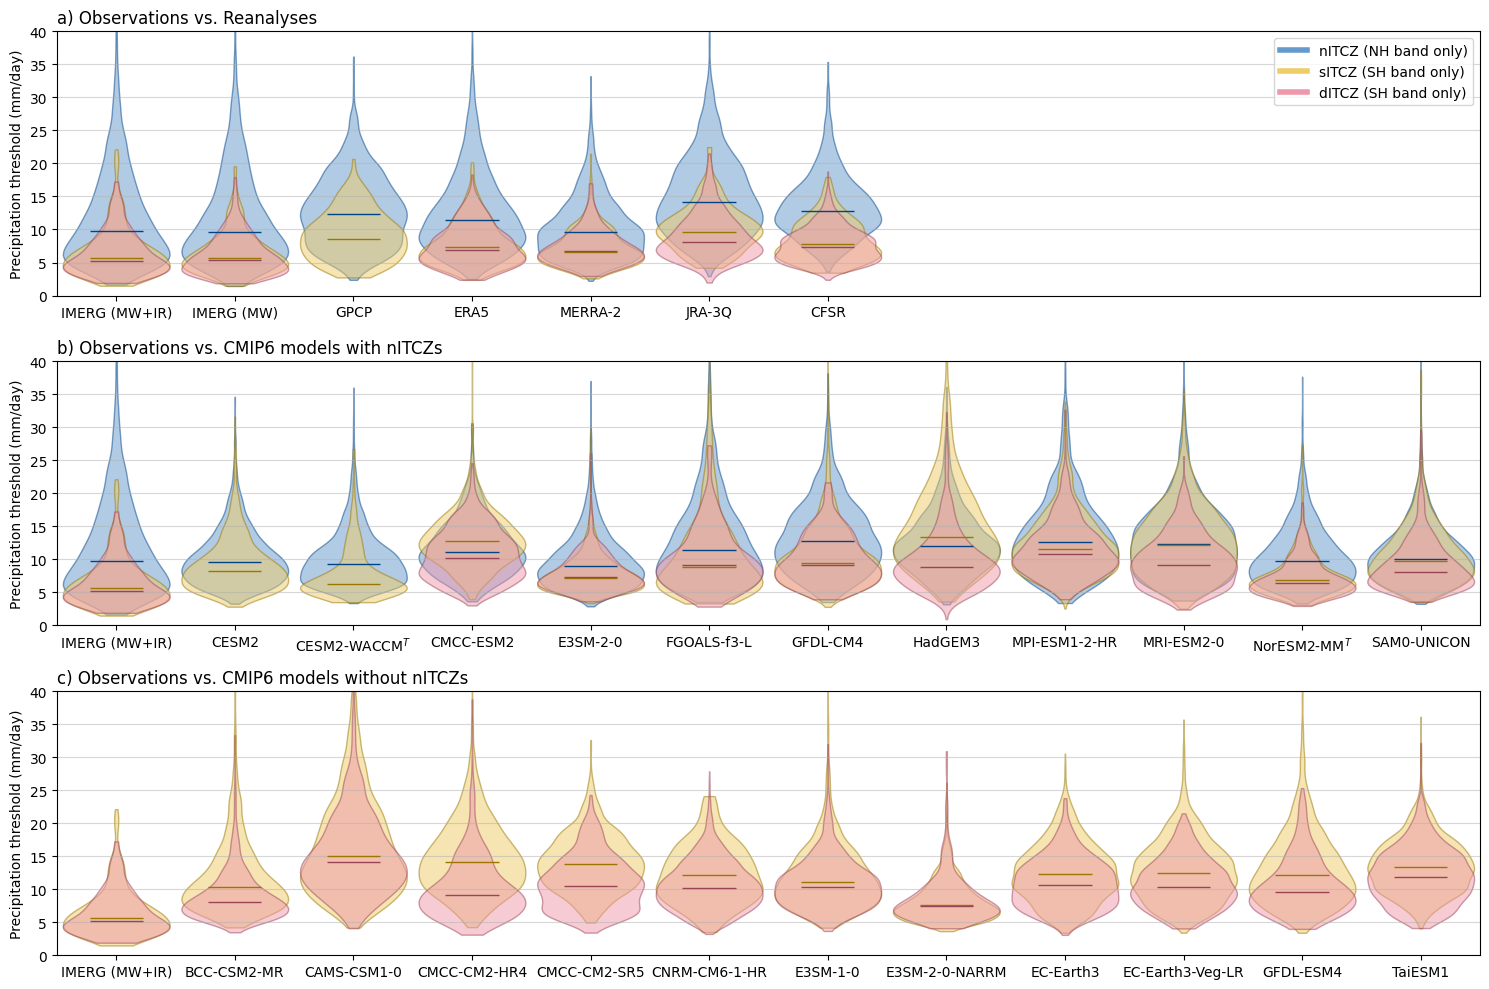

In [52]:
# plot violin plot
npan = 3
from matplotlib.lines import Line2D

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(15, 10), tight_layout='true')
#fig.suptitle(r'Precipitation threshold distribution for '+region_ti+' Ocean ITCZ states ('+mn_str+', '+yr_str+')',fontsize='xx-large')
for jj in range(0,npan,1):
    ax = fig.add_subplot(npan,1,jj+1)
    plt.ylim(0,40)
    if jj == 0:
        ax1 = ax.violinplot([pr_thresh_nI_tmpa,pr_thresh_nI_imerg,pr_thresh_nI_gpcp,pr_thresh_nI_era5,pr_thresh_nI_merra2,pr_thresh_nI_jra55,pr_thresh_nI_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#6699CC')
            vp.set_edgecolor('#004488')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1) 
        ax1 = ax.violinplot([pr_thresh_sI_tmpa,pr_thresh_sI_imerg,pr_thresh_sI_gpcp,pr_thresh_sI_era5,pr_thresh_sI_merra2,pr_thresh_sI_jra55,pr_thresh_sI_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        for vp in ax1['bodies']:
            vp.set_facecolor('#EECC66')
            vp.set_edgecolor('#997700')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#997700')
        vp.set_linewidth(1) 

        ax1 = ax.violinplot([pr_thresh_dI_SH_tmpa,pr_thresh_dI_SH_imerg,pr_thresh_dI_SH_gpcp*-9999,pr_thresh_dI_SH_era5,pr_thresh_dI_SH_merra2,pr_thresh_dI_SH_jra55,pr_thresh_dI_SH_cfsr],
                          showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#EE99AA')
            vp.set_edgecolor('#994455')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#994455')
        vp.set_linewidth(1)
            
        ax.set_title('a) Observations vs. Reanalyses', loc='left')
        ax.set_xticks(np.arange(1,8,1), labels=dataset_reana_plt)
        plt.xlim(0.5,12.5)
    #ax.set_xticks(np.arange(1,7,1), labels=dataset)
    
        custom_lines = [Line2D([0], [0], color='#6699CC', lw=4),
                Line2D([0], [0], color='#EECC66', lw=4),
                Line2D([0], [0], color='#EE99AA', lw=4)]

        ax.legend(custom_lines, ['nITCZ (NH band only)', 'sITCZ (SH band only)', 'dITCZ (SH band only)'])
    if jj == 1:
        ax1 = ax.violinplot([pr_thresh_nI_tmpa,pr_thresh_nI_CESM2,pr_thresh_nI_CESM2W,pr_thresh_nI_CMCCE, pr_thresh_nI_E3SM2, \
                             pr_thresh_nI_FGOALS,pr_thresh_nI_GFDLC,pr_thresh_nI_Had,pr_thresh_nI_MPI, pr_thresh_nI_MRI, \
                             pr_thresh_nI_Nor,pr_thresh_nI_SAM],
                             showmeans=False,showmedians=True,showextrema=False,widths=0.9)
        
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#6699CC')
            vp.set_edgecolor('#004488')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1) 
        
        ax1 = ax.violinplot([pr_thresh_sI_tmpa,pr_thresh_sI_CESM2,pr_thresh_sI_CESM2W,pr_thresh_sI_CMCCE, pr_thresh_sI_E3SM2, \
                             pr_thresh_sI_FGOALS,pr_thresh_sI_GFDLC,pr_thresh_sI_Had,pr_thresh_sI_MPI, pr_thresh_sI_MRI, \
                             pr_thresh_sI_Nor,pr_thresh_sI_SAM],
                             showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        for vp in ax1['bodies']:
            vp.set_facecolor('#EECC66')
            vp.set_edgecolor('#997700')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#997700')
        vp.set_linewidth(1) 
        ax1 = ax.violinplot([pr_thresh_dI_SH_tmpa,pr_thresh_dI_SH_CESM2*-9999,pr_thresh_dI_SH_CESM2W*-9999, \
                             pr_thresh_dI_SH_CMCCE,pr_thresh_dI_SH_E3SM2, pr_thresh_dI_SH_FGOALS,\
                             pr_thresh_dI_SH_GFDLC, pr_thresh_dI_SH_Had,\
                             pr_thresh_dI_SH_MPI, pr_thresh_dI_SH_MRI, \
                             pr_thresh_dI_SH_Nor,pr_thresh_dI_SH_SAM],
                             showmeans=False,showmedians=True,showextrema=False,widths=0.9)
        
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#EE99AA')
            vp.set_edgecolor('#994455')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#994455')
        vp.set_linewidth(1)
            
        ax.set_title('b) Observations vs. CMIP6 models with nITCZs', loc='left')

        custom_lines = [Line2D([0], [0], color='#6699CC', lw=4),
                Line2D([0], [0], color='#EECC66', lw=4),
                Line2D([0], [0], color='#EE99AA', lw=4)]
        #ax.legend(custom_lines, ['nITCZ (NH band only, Feb-Apr)', 'sITCZ (SH band only, Feb-Apr)', 'dITCZ (mean of NH and SH bands, Jan–May)'])

        ax.set_xticks(np.arange(1,13,1), labels=pr_thresh_plt1_names)
        plt.xlim(0.5,12.5)
    if jj == 2:
        ax1 = ax.violinplot([pr_thresh_sI_tmpa,pr_thresh_sI_bcc,pr_thresh_sI_cams,pr_thresh_sI_CMCCH, \
                             pr_thresh_sI_CMCCS, pr_thresh_sI_CNRM,pr_thresh_sI_E3SM1,pr_thresh_sI_E3SM2N, \
                             pr_thresh_sI_ECEarth3,pr_thresh_sI_ECEarth3VL, pr_thresh_sI_GFDLE, pr_thresh_sI_Tai],
                             showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        for vp in ax1['bodies']:
            vp.set_facecolor('#EECC66')
            vp.set_edgecolor('#997700')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#997700')
        vp.set_linewidth(1) 
        
        ax1 = ax.violinplot([pr_thresh_dI_SH_tmpa,pr_thresh_dI_SH_bcc,pr_thresh_dI_SH_cams, \
                             pr_thresh_dI_SH_CMCCH,pr_thresh_dI_SH_CMCCS,pr_thresh_dI_SH_CNRM, \
                             pr_thresh_dI_SH_E3SM1,pr_thresh_dI_SH_E3SM2N,pr_thresh_dI_SH_ECEarth3, \
                             pr_thresh_dI_SH_ECEarth3VL,pr_thresh_dI_SH_GFDLE,pr_thresh_dI_SH_Tai],
                             showmeans=False,showmedians=True,showextrema=False,widths=0.9)

        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
            vp.set_facecolor('#EE99AA')
            vp.set_edgecolor('#994455')
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#994455')
        vp.set_linewidth(1)

        ax.set_title('c) Observations vs. CMIP6 models without nITCZs', loc='left')
        ax.set_xticks(np.arange(1,13,1), labels=pr_thresh_plt2_names)
        plt.xlim(0.5,12.5)

    ax.yaxis.grid(alpha=0.5,zorder=-1)

    plt.ylabel('Precipitation threshold (mm/day)')
    
plt.savefig(figfolder+figname,bbox_inches="tight",transparent=False,dpi=150)